In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os, glob
import numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

BASE = '/content/drive/MyDrive/DATA'
soh_levels = ['100% SOH','95% SOH','90% SOH','85% SOH','80% SOH']

I_list, U_list, SOC_list, SOH_list = [], [], [], []

for s in soh_levels:
    folder = os.path.join(BASE, s)
    I = pd.read_csv(os.path.join(folder,'I.csv'), header=None).values.astype(np.float32)
    U = pd.read_csv(os.path.join(folder,'U.csv'), header=None).values.astype(np.float32)
    SOC = pd.read_csv(os.path.join(folder,'SOC.csv'), header=None).values.astype(np.float32)
    level = float(s.replace('% SOH',''))  # e.g. 100, 95, ...
    SOH = np.full_like(SOC, level/100.0, dtype=np.float32)
    I_list.append(I);    U_list.append(U)
    SOC_list.append(SOC); SOH_list.append(SOH)

I_data   = np.vstack(I_list)
U_data   = np.vstack(U_list)
SOC_data = np.vstack(SOC_list)
SOH_data = np.vstack(SOH_list)

print("Shapes:", I_data.shape, U_data.shape, SOC_data.shape, SOH_data.shape)
# e.g. (5*13686, 300) for each


Shapes: (68430, 300) (68430, 300) (68430, 300) (68430, 300)


In [ ]:
class BatteryDataset(Dataset):
    def __init__(self, I, U, SOC, SOH):
        self.X = np.stack([I, U], axis=2)    # (N,300,2)
        self.Y = np.stack([SOC, SOH], axis=2)  # (N,300,2)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return (torch.from_numpy(self.X[i]), torch.from_numpy(self.Y[i]))

# 80/20 split
n = len(I_data)
train_n = int(n*0.8)
ds_train = BatteryDataset(I_data[:train_n], U_data[:train_n],
                          SOC_data[:train_n], SOH_data[:train_n])
ds_val   = BatteryDataset(I_data[train_n:], U_data[train_n:],
                          SOC_data[train_n:], SOH_data[train_n:])

train_loader = DataLoader(ds_train, batch_size=64, shuffle=True)
val_loader   = DataLoader(ds_val,   batch_size=64, shuffle=False)


In [ ]:
class SOC_SOH_RNN(nn.Module):
    def __init__(self, hidden_size=64, num_layers=3, dropout=0.1):
        super().__init__()
        self.rnn = nn.GRU(input_size=2,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout,
                          batch_first=True)
        self.head_soc = nn.Linear(hidden_size, 1)
        self.head_soh = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (B,300,2)
        out, _ = self.rnn(x)           # (B,300,H)
        soc = self.head_soc(out)       # (B,300,1)
        soh = self.head_soh(out)       # (B,300,1)
        return torch.cat([soc, soh], dim=2)  # (B,300,2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SOC_SOH_RNN(hidden_size=128, num_layers=4, dropout=0.2).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
crit  = nn.MSELoss()


In [ ]:
from tqdm import trange

best_val = 1e9
patience = 5
wait = 0

train_hist, val_hist = [], []

for epoch in trange(1, 1):
    # --- train ---
    model.train()
    total_loss = 0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = crit(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()*yb.numel()
    train_rmse = np.sqrt(total_loss/ (len(ds_train)*300*2)) *100
    train_hist.append(train_rmse)

    # --- validate ---
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_loss += crit(pred, yb).item()*yb.numel()
    val_rmse = np.sqrt(total_loss/ (len(ds_val)*300*2)) *100
    val_hist.append(val_rmse)

    # early stop
    if val_rmse < best_val:
        best_val = val_rmse; wait=0
        torch.save(model.state_dict(), 'best.pth')
    else:
        wait += 1
        if wait>=patience:
            print(f"Early stopping at epoch {epoch}")
            break

    print(f"Epoch {epoch:02d} → train {train_rmse:.2f}%  val {val_rmse:.2f}%")


 11%|█         | 1/9 [00:19<02:37, 19.63s/it]

Epoch 01 → train 11.79%  val 9.59%


 22%|██▏       | 2/9 [00:38<02:14, 19.21s/it]

Epoch 02 → train 6.07%  val 10.98%


 33%|███▎      | 3/9 [00:57<01:55, 19.24s/it]

Epoch 03 → train 5.74%  val 8.67%


 44%|████▍     | 4/9 [01:16<01:35, 19.17s/it]

Epoch 04 → train 5.47%  val 9.14%


 56%|█████▌    | 5/9 [01:36<01:16, 19.23s/it]

Epoch 05 → train 5.41%  val 9.42%


 67%|██████▋   | 6/9 [01:56<00:58, 19.47s/it]

Epoch 06 → train 5.29%  val 9.99%


 78%|███████▊  | 7/9 [02:16<00:39, 19.60s/it]

Epoch 07 → train 5.31%  val 11.47%


 78%|███████▊  | 7/9 [02:35<00:44, 22.24s/it]

Early stopping at epoch 8


SOC RMSE: 6.045332908630371 SOH RMSE: 10.672850608825684


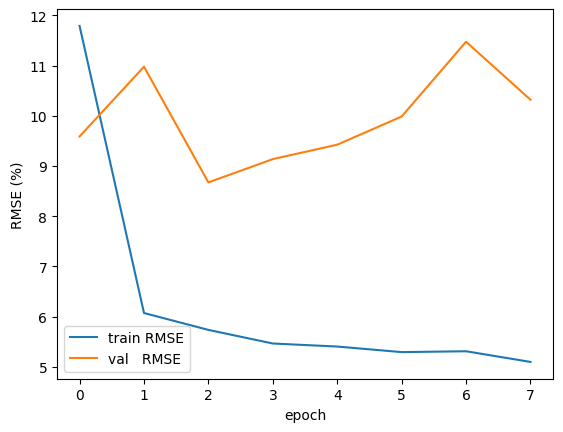

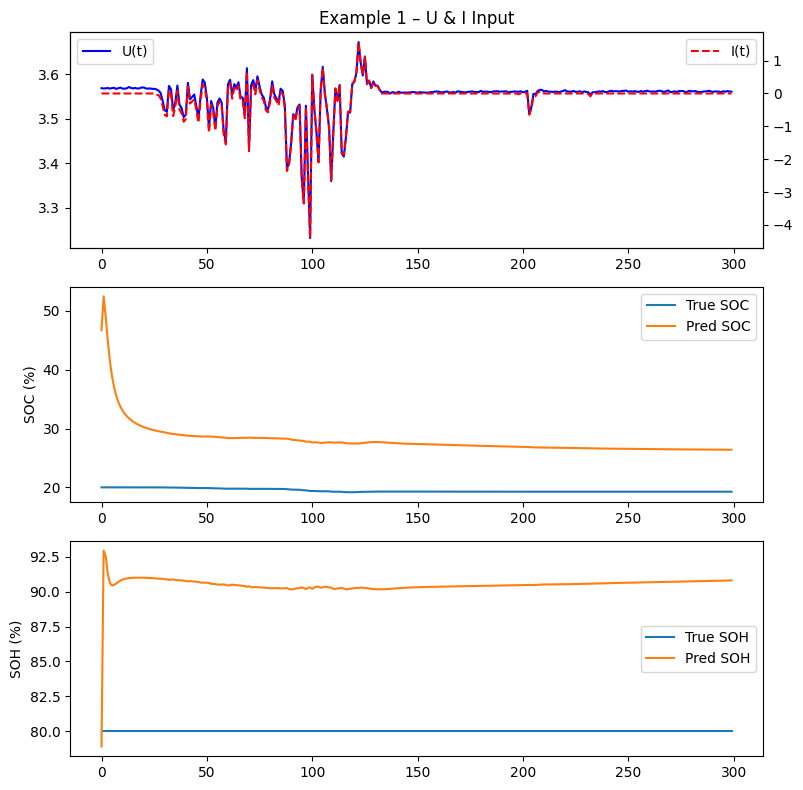

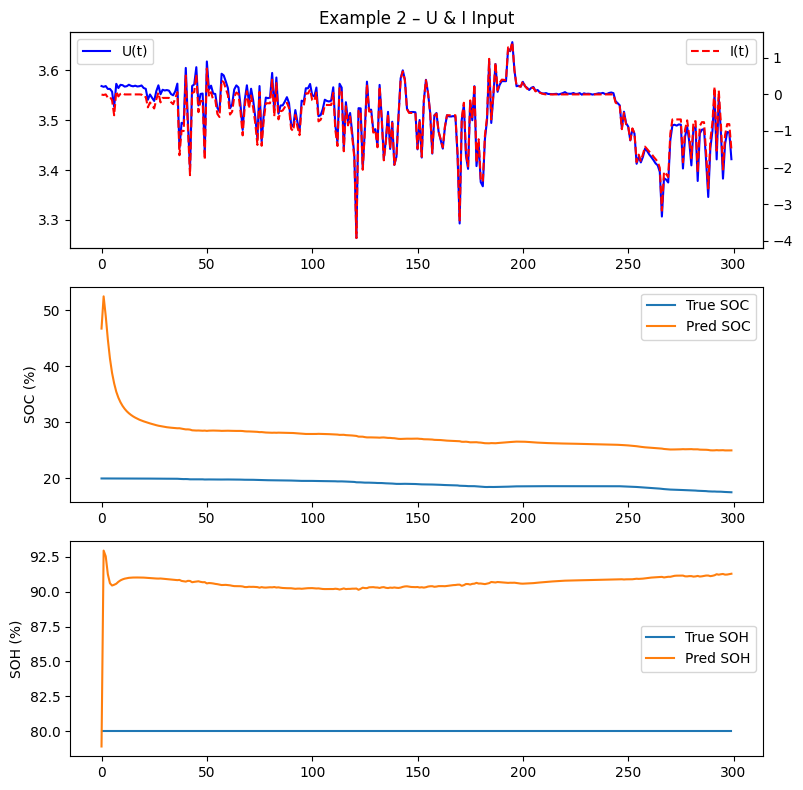

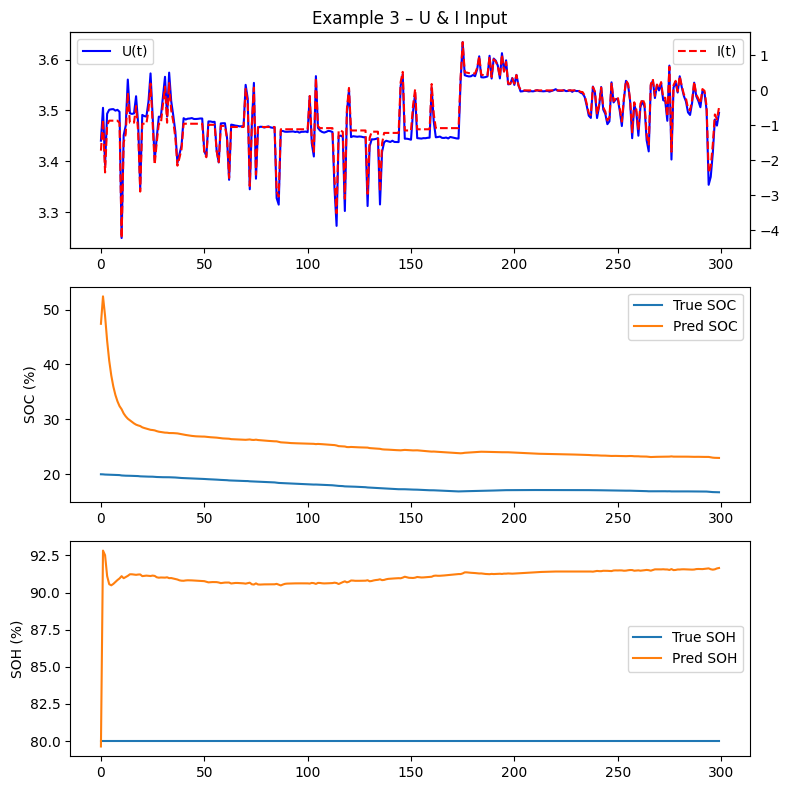

In [ ]:
# load best
model.load_state_dict(torch.load('best.pth'))
model.eval()

# gather all test sequences
all_pred, all_true, all_in = [], [], []
with torch.no_grad():
    for xb,yb in val_loader:
        xb,yb = xb.to(device), yb.to(device)
        out = model(xb).cpu()   # (B,300,2)
        all_pred.append(out);   all_true.append(yb.cpu()); all_in.append(xb.cpu())
P = torch.cat(all_pred)
T = torch.cat(all_true)
X = torch.cat(all_in)

# split
soc_p, soh_p = P[:,:,0], P[:,:,1]
soc_t, soh_t = T[:,:,0], T[:,:,1]

# overall metrics
def rmse(a,b): return torch.sqrt(((a-b)**2).mean())*100
print("SOC RMSE:", rmse(soc_p, soc_t).item(),
      "SOH RMSE:", rmse(soh_p, soh_t).item())

# plot loss curves
plt.plot(train_hist, label='train RMSE')
plt.plot(val_hist,   label='val   RMSE')
plt.xlabel('epoch'); plt.ylabel('RMSE (%)'); plt.legend()
plt.show()

# plot 3 examples
for i in range(3):
    fig, axs = plt.subplots(3,1,figsize=(8,8))
    t = np.arange(300)

    # U & I
    axs[0].plot(t, X[i,:,1], 'b-', label='U(t)')
    axs0 = axs[0].twinx()
    axs0.plot(t, X[i,:,0], 'r--', label='I(t)')
    axs[0].legend(loc='upper left'); axs0.legend(loc='upper right')
    axs[0].set_title(f"Example {i+1} – U & I Input")

    # SOC
    axs[1].plot(t, soc_t[i]*100, label='True SOC')
    axs[1].plot(t, soc_p[i]*100, label='Pred SOC')
    axs[1].set_ylabel("SOC (%)"); axs[1].legend()

    # SOH
    axs[2].plot(t, soh_t[i]*100, label='True SOH')
    axs[2].plot(t, soh_p[i]*100, label='Pred SOH')
    axs[2].set_ylabel("SOH (%)"); axs[2].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# load best
model.load_state_dict(torch.load('best.pth'))
model.eval()

  total_infer_time = 0.0
  total_samples = 0

# gather all test sequences
all_pred, all_true, all_in = [], [], []
with torch.no_grad():
    for xb,yb in val_loader:
        xb,yb = xb.to(device), yb.to(device)

        start_time = time.time()
        out = model(xb)
        end_time = time.time()

        total_infer_time += (end_time - start_time)
        total_samples += xb.size(0)

print(f"Number of Samples: {total_samples}")

avg_infer_time = total_infer_time / total_samples
print(f"Average Inference Time per Sample: {avg_infer_time * 1e6:.1f} µs")